In [2]:
#先导入所需的库，主要用到了tensor，torch.nn的Module父类进行初始化，optimizer优化器
#tensor可以保存梯度，如果多次计算梯度会累加
#Module中存在parameters()可以用于后续参数的反向传播,loss.backword()获得梯度
#optimizer进行参数调优,optimizer.step()，由保存的梯度进行调优，注意每次要先梯度清零
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np

In [3]:
#自定义卷积网络，两层卷积层，一层全连接层，激活函数使用了ReLU
class ConvNet(nn.Module):
    def __init__(self,num_class=10):
        super().__init__()#类别数指定，默认为10
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),#卷积层，1通道转32通道，输入m*28*28，卷积后因为有padding，m*16*28*28
            nn.BatchNorm2d(16),#标准化
            nn.ReLU(),#激活函数
            nn.MaxPool2d(kernel_size=2,stride=2)#最大池化，池化后尺寸缩半,m*14*14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=5,stride=1,padding=2),#m*32*14*14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)#m*32*7*7
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,48,kernel_size=4,stride=1,padding=1),#m*48*6*6
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)#m*48*3*3
        )
        self.fc = nn.Linear(3*3*48,num_class)
        
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=out.reshape(out.size(0),-1)#特征拉直，m*(32*7*7)
        out=self.fc(out)#输出为m*10
        return out

In [54]:
# 将张量转移到GPU，并下载MNIST数据集（手写数字图片）
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #如果有cuda 就用GPU，没有就用CPU

#  超参数
num_epochs = 5 #训练5轮
num_classes = 10 #类别10，数字0~9
batch_size = 100 #一次送入100个数据
learning_rate = 0.001 #梯度下降步长

# 数据集与加载torchvision中已经集成了，直接调用
train_dataset = torchvision.datasets.MNIST(root='./dataset/',
                                           train=True, #如果为False则选用测试集
                                           transform=transforms.ToTensor(),#转换为张量
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./dataset/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# 使用了DataLoader类生成迭代器，每次加载batch_size个数据，防止数据导入过多内存不够
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)#训练时，数据打乱

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False) #测试时，不打乱

轮数 [1/5], 进度 [100/600], Loss: 0.2880
轮数 [1/5], 进度 [200/600], Loss: 0.2293
轮数 [1/5], 进度 [300/600], Loss: 0.1483
轮数 [1/5], 进度 [400/600], Loss: 0.1090
轮数 [1/5], 进度 [500/600], Loss: 0.1004
轮数 [1/5], 进度 [600/600], Loss: 0.0814
轮数 [2/5], 进度 [100/600], Loss: 0.0945
轮数 [2/5], 进度 [200/600], Loss: 0.0598
轮数 [2/5], 进度 [300/600], Loss: 0.0473
轮数 [2/5], 进度 [400/600], Loss: 0.0750
轮数 [2/5], 进度 [500/600], Loss: 0.0424
轮数 [2/5], 进度 [600/600], Loss: 0.0603
轮数 [3/5], 进度 [100/600], Loss: 0.0818
轮数 [3/5], 进度 [200/600], Loss: 0.0731
轮数 [3/5], 进度 [300/600], Loss: 0.0297
轮数 [3/5], 进度 [400/600], Loss: 0.0404
轮数 [3/5], 进度 [500/600], Loss: 0.1080
轮数 [3/5], 进度 [600/600], Loss: 0.0954
轮数 [4/5], 进度 [100/600], Loss: 0.0877
轮数 [4/5], 进度 [200/600], Loss: 0.0465
轮数 [4/5], 进度 [300/600], Loss: 0.1029
轮数 [4/5], 进度 [400/600], Loss: 0.0157
轮数 [4/5], 进度 [500/600], Loss: 0.0285
轮数 [4/5], 进度 [600/600], Loss: 0.0460
轮数 [5/5], 进度 [100/600], Loss: 0.0643
轮数 [5/5], 进度 [200/600], Loss: 0.0505
轮数 [5/5], 进度 [300/600], Loss: 0.0326
轮

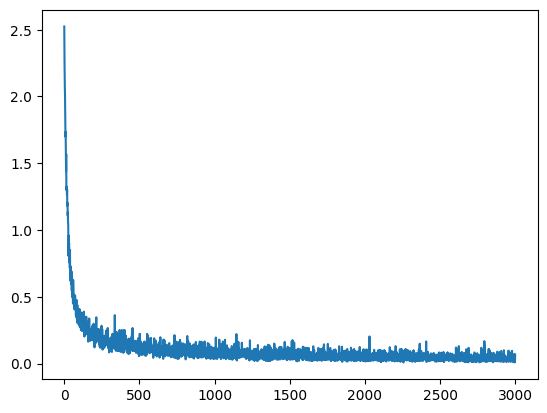

In [87]:
# 模型初始化
model = ConvNet().to(device)

# Loss and optimizer 损失和优化器
criterion = nn.CrossEntropyLoss() #交叉熵
optimizer = torch.optim.ASGD(model.parameters(), lr=0.01)#learning_rate
myloss=[]

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #images = torch.Tensor(np.abs(np.fft.fft2(images)))
        images = images.to(device) #images模型输入
        labels = labels.to(device) #labels用于计算loss
        
        # 前向传播,即网络如何根据输入得到输出的
        outputs = model(images)
        # loss计算
        loss = criterion(outputs, labels)
        myloss.append(loss.item())
        
        # 反向传播与优化,反向传播算法的核心是代价函数对网络中参数（各层的权重和偏置）的偏导表达式和。
        optimizer.zero_grad() #梯度清零：重置模型参数的梯度。默认是累加，为了防止重复计数，在每次迭代时显式地将它们归零。
        loss.backward()#反向传播计算梯度：计算当前张量w.r.t图叶的梯度。
        optimizer.step()#参数更新：根据上面计算的梯度，调整参数
        
        if (i+1) % 100 == 0: #每个batch打印以此结果
            print ('轮数 [{}/{}], 进度 [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        #训练集损失小不一定真的好，没必要在训练时保存最小损失时的模型
plt.plot(myloss)

In [89]:
# 模型测试
model.eval()#使用训练学到的均值和方差，禁止BN层继续学习mean和var 
with torch.no_grad(): #禁用梯度计算，节省时间，model.eval()已经可以保证正确
    correct = 0
    total = 0
    for images, labels in test_loader:
        #images = torch.Tensor(np.abs(np.fft.fft2(images)))
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) #找出类别里最大的预测结果
        total += labels.size(0) #统计测试总数
        correct += (predicted == labels).sum().item() #统计预测正确总数
    
    print('模型在10000个测试图片的正确率为: {} %'.format(100 * correct / total))

模型在10000个测试图片的正确率为: 98.72 %


In [90]:
# 模型导出
#PyTorch模型将学习到的参数存储在一个内部状态字典中，称为state_dict。使用torch.save()保存
torch.save(model.state_dict(), './checkpoint/model.pth')

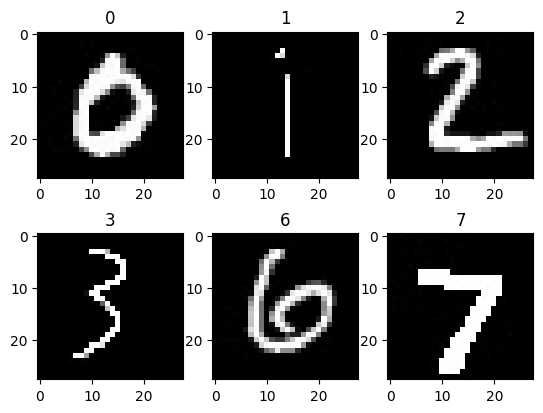

In [91]:
import numpy as np
import os
import cv2


#模型加载
model=ConvNet(10) #类别，数字0~9,10类
state_dict=torch.load('./checkpoint/model.pth')
model.load_state_dict(state_dict)
model.eval() #有BN和Dropout，测试时要加model.eval()。
test_dir = 'dataset/MNISTtest'
with torch.no_grad():
    #数据加载
    i=0
    for pic in os.listdir(test_dir):
        image=cv2.imread(os.path.join(test_dir, pic),0) #读入灰度图，WH两个维度 28*28
        #print(image.shape)
        if(image.shape != (28,28)): #如果不是28*28，resize为28*28
            image = cv2.resize(image,(28,28))
        image = image/255.0 #归一化到0到1，，因为测试图片是白底黑字，但训练集是黑底白字，做一个反色1.0-image
        #image = np.abs(np.fft.fft2(image))
        image_t = np.expand_dims(image, 0) # 增加1个维度
        image_t = np.expand_dims(image_t, 0) # 再增加一个维度
        image_t = image_t.astype(np.float32)
        #print(image.shape) #1*1*28*28，batch，通道数，H,W
        image_t=torch.from_numpy(image_t) #转成Torch的张量
        outputs = model(image_t)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1) # 输出0~9模型中分值最高的
        plt.subplot(2,3,i+1)
        plt.imshow(image,cmap='gray')
        plt.title(predicted.item())
        i+=1
        #print("test end")

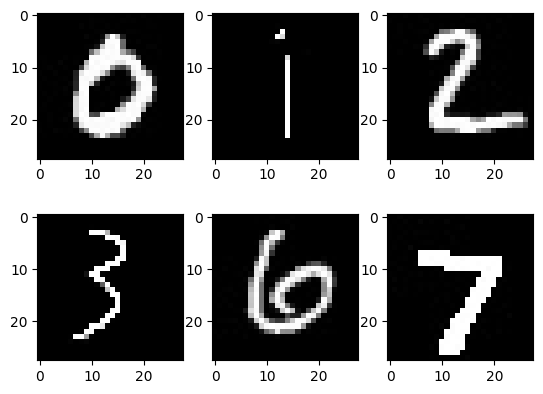

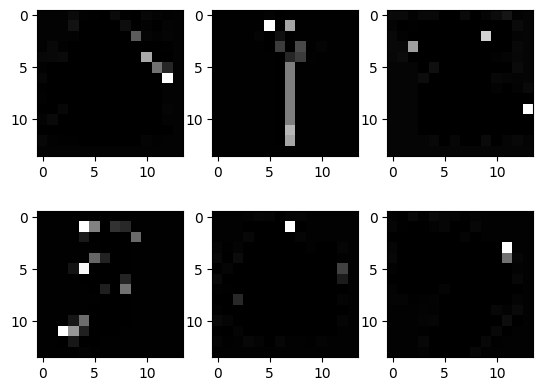

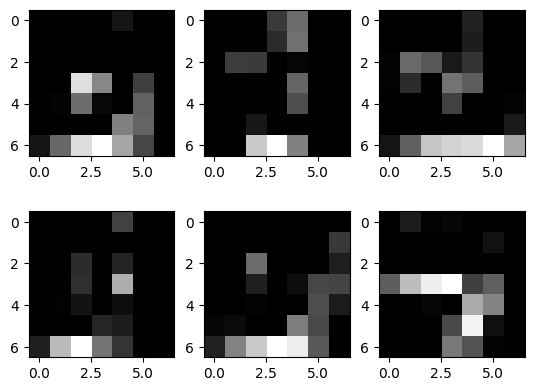

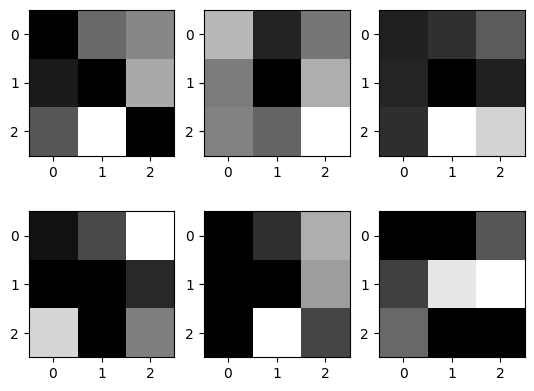

In [92]:
from matplotlib import pyplot as plt
import cv2
import os
test_dir = 'dataset/MNISTtest'
with torch.no_grad():
    layer1 = model.layer1
    layer2 = model.layer2
    layer3 = model.layer3
    
    i = 0
    for pic in os.listdir(test_dir):
        i=i+1
        img=cv2.imread(os.path.join(test_dir, pic),0) #读入灰度图，WH两个维度 28*28
        if(img.shape != (28,28)): #如果不是28*28，resize为28*28
            img = cv2.resize(img,(28,28))
        #img = np.abs(np.fft.fft2(img))
        plt.figure(1)
        plt.subplot(2,3,i)
        plt.imshow(img,cmap='gray')
        image_t = np.expand_dims(img, 0) # 增加1个维度
        image_t = np.expand_dims(image_t, 0) # 再增加一个维度
        image_t = torch.from_numpy(np.float32(image_t)) #转成Torch的张量
        out1 = layer1(image_t)
        out2 = layer2(out1)
        out3 = layer3(out2)
        out1 = np.array(torch.squeeze(out1))
        out2 = np.array(torch.squeeze(out2))
        out3 = np.array(torch.squeeze(out3))
        plt.figure(2)
        plt.subplot(2,3,i)
        plt.imshow(out1[0],cmap='gray')
        plt.figure(3)
        plt.subplot(2,3,i)
        plt.imshow(out2[0],cmap='gray')
        plt.figure(4)
        plt.subplot(2,3,i)
        plt.imshow(out3[0],cmap='gray')